<table>
  <tr>
      <td><div style="white-space: pre-wrap;" align="left"><font size="30" >Tutorial B2&#10;SLAM </font></div></td>
     <td><img src="image/RVSS-logo.png" width="400"></td>
  </tr>
</table>

# Load data and run SLAM

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
importing Jupyter notebook from Renderer.ipynb
importing Jupyter notebook from SLAM_Robot.ipynb
importing Jupyter notebook from Measurements.ipynb
importing Jupyter notebook from Slam.ipynb


<IPython.core.display.Javascript object>


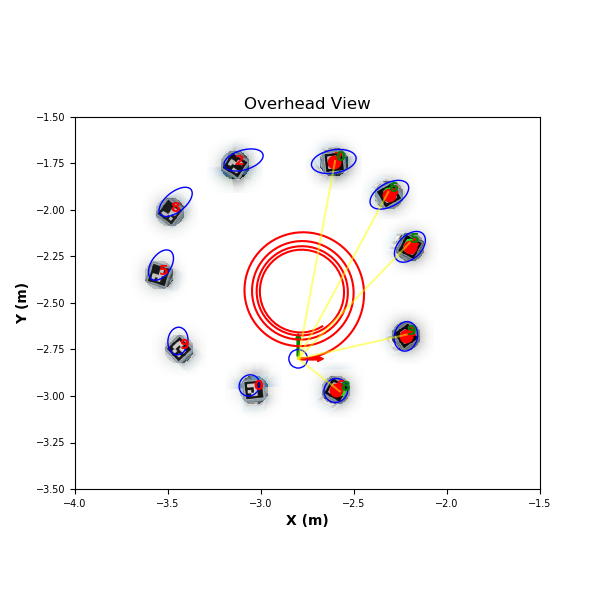

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=299), …

In [1]:
#Import all the nessesary modules
import sys
!{sys.executable} -m pip install import_ipynb

%matplotlib notebook
import matplotlib.pyplot as plt
import import_ipynb
import math
import numpy as np
import pickle
#widgest allows interactive elements 
from ipywidgets import *
#Here we import from a python file support functions to visualize our robot
from importlib import import_module
#Visualizer
from Renderer import *
#Here we import Robot class definition form the other notebook
from SLAM_Robot import *
#Here we import a class that defines out measurments
from Measurements import *
#Here is SLAM
import Slam

#Here we load our data including the true state 
with open('data/data_slam.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']

#Now lets see how well slam does
#Create a robot and place it at the true starting position and orientation 
bot = SLAM_Robot(0.14, 0.01)
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = gt_state[0,:].copy().reshape(-1,1)

slammer = Slam.Slam(bot)

#----------------------------------------PARAMETERS----------------------------------
#
#Initial incertainty of our robot
slammer.P = np.eye(3)*0.1
#Uncertainty in our left and right wheel motors
sigma_drive = np.array([1,1])
#Uncertainty in measurement ~10cm
sigma_measure = np.eye(2)*0.5
#
#-------------------------------------------------------------------------------------

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))
#Here we will save all of the landmarks added to our map
landmarks = []
#Here we save the robot covariances
robot_cov = np.zeros(((control.shape[0],3,3)))
#Here we save the marker covariances
marker_cov = []
for c in range(control.shape[0]):
    #Set the measurement covariances
    for mes in measurements[c]:
        mes.covariance = sigma_measure 
    
    slammer.add_landmarks(measurements[c])
    # Drive and predict
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    slammer.predict(drive_signal)
    slammer.update(measurements[c])
    
    marker_cov.append(slammer.P[3:,3:])
    state[c,:] = bot.state[:,0]
    landmarks.append(slammer.markers)
    robot_cov[c,:,:] = slammer.P[0:3,0:3]
    
#Create a visualizer and visualize our atate
rend = Rendered.Instance()
rend.initialize(state,measurements,gt_state = gt_state,landmarks=landmarks,robot_cov=robot_cov,marker_cov=marker_cov)
